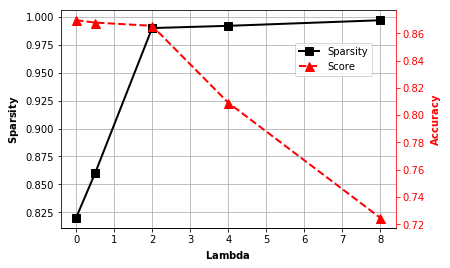

In [3]:
import cv2
import os
import torch 
import numpy as np
import sys
import matplotlib.pyplot as plt

lambda_i = [0, 0.5, 2, 4, 8]

# C3D
# axis_y = [0.967114, 0.967, 0.964492, 0.960856, 0.949976]
# sparsity = [0.64, 0.89, 0.90, 0.96, 0.97]
# lable_2 = 'Accuracy'
# label_data = ["(0, 0, 0, 0, 0, 0, 0, 0)",
#               "(3, 3, 3, 3, 3, 3, 3, 3)",
#               "(7, 2, 3, 2, 3, 3, 4, 4)",
#               "(10, 7, 5, 5, 5, 5, 5, 2)",
#               "(17, 9, 5, 5, 6, 6, 6, 5)"
#             ]

# 3D Unet
axis_y = [0.8695406, 0.8678476, 0.8654427, 0.8090884, 0.7245791]
label_2 = 'Score'
sparsity = [0.82, 0.86, 0.99, 0.992, 0.997]
label_data = ["(0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0)",
              "(0, 0, 0, 1, 1, 1, 1, 1, 1, 1,   1, 1, 1, 1, 1, 1, 1, 1, 1, 1,   1, 1, 1, 1, 1, 1, 1, 1, 0, 0)",
              "(0, 1, 4, 5, 3, 3, 4, 4, 5, 5,   5, 5, 4, 5, 5, 5, 4, 5, 5, 5,   5, 5, 5, 5, 5, 5, 5, 5, 5, 5)",
              "(1, 1, 0, 10, 3, 9, 10, 10, 11, 11,   10, 10, 10, 9, 11, 11, 11, 10, 10, 11,   11, 11, 11, 11, 11, 11, 11, 11, 9, 12)",
              "(0, 1, 0, 21, 0, 16, 21, 21, 21, 22,   21, 21, 18, 22, 22, 22, 20, 20, 22, 22,   22, 21, 21, 17, 22, 21, 22, 22, 20, 23)",
            ]



fig, ax = plt.subplots(1,1)
color = (0, 0, 0)
ax.plot(lambda_i, sparsity, 'x-', marker='s', color=color,  linewidth=2, markersize=8, label='Sparsity')
# for i in range(5):
#     ax.text(lambda_i[i], sparsity[i],label_data[i], verticalalignment='top', horizontalalignment='right' )
ax.set_xlabel(r"$\bf{Lambda}$"+' ' + r"$\bf{}$", size=10, family="Arial")
ax.set_ylabel(r"$\bf{Sparsity}$"+' ' + r"$\bf{(%)}$", size=10, color=color)

plt.grid(True)
from matplotlib.pyplot import MultipleLocator
inst = plt.gca()

ax1 = ax.twinx()
color1 = (1, 0, 0)
ax1.plot(lambda_i, axis_y, '--', marker='^', color=color1,  linewidth=2, markersize=9, label=label_2)
ax1.set_ylabel(r"$\bf{Accuracy}$"+' ' + r"$\bf{}$", size=10, color=color1)

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax1.get_legend_handles_labels()
plt.legend(handles1+handles2, labels1+labels2, loc=(0.7, 0.7))

ax.spines['left'].set_color(color)
ax.tick_params(axis='y', colors=color)

ax.spines['right'].set_visible(False)

ax1.spines['right'].set_color(color1)
ax1.tick_params(axis='y', colors=color1)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.savefig(os.path.join(sys.path[0],'lambda.svg'), format='svg')
plt.show()

In [16]:
import numpy as np
from matplotlib import pyplot as plt
class cls_plt_fig():
    def __init__(self, name):
        self.name = name
    def func_plt_fig(self, fig_dict={   "x_name":"Conv Layers", 
            "x_value": np.arange(3), 
            "x_label" : r"$\bf{Conv}$"+' ' +r"$\bf{Layers}$",
            "y1_fig_type": "bar",
            "y1_name":"speedup",
            "y1_value":[1], 
            "y1_color":(0, 0, 0),
            "y1_linestyle":'x-',
            "y1_label":r"$\bf{Speedup}$",
            "y1_marker":'s',
            "y1_legend": r"$\bf{Speedup}$",
            "y1_yticks_max": 18,
            "y2_fig_type": "bar",
            "y2_name":"energy_efficiency",
            "y2_value":[1],
            "y2_color":(1, 0, 0),
            "y2_linestyle":'--',
            "y2_label":r"$\bf{Energy}$" + ' ' + r"$\bf{efficiency}$"+' ' + r"$\bf{(TOPS/W)}$",
            "y2_marker":'^',
            "y2_legend": r"$\bf{Energy}$" + ' ' + r"$\bf{efficiency}$",
            "y2_yticks_max": 12,
            "grid_axis": 'both',
            "linewidth": 2,
            "markersize": 8,
            "family":"Arial",
            "label_size": 10,
            "bar_width": 0.4,
            "xticks": "layer",
            "plt_text": True,
            "legend_loc": (0.65, 0.8),
            "fig_name" :'../../generate/speedup&EE_layer.svg'
            }): # dict
        fig, ax = plt.subplots(figsize=fig_dict["figsize"] if "figsize" in fig_dict else (7, 4.6))
        color = fig_dict["y1_color"]
        family = fig_dict["family"]
        label_size = fig_dict["label_size"]
        if 'grid' in fig_dict:
            plt.grid(axis=fig_dict['grid'], zorder=0) #, 
        for idx_y in range(len(fig_dict["y1_name"])):
            if fig_dict['y1_fig_type'] == 'plot':
                ax.plot(fig_dict["x_value"], fig_dict["y1_value"][idx_y], fig_dict["y1_linestyle"], marker=fig_dict["y1_marker"][idx_y], color=color[idx_y],  linewidth=fig_dict["linewidth"], markersize=fig_dict["markersize"], label=fig_dict["y1_legend"][idx_y], zorder=10, markerfacecolor= fig_dict["y1_markerfacecolor"] if "y1_markerfacecolor" in fig_dict else None, markeredgewidth = fig_dict["y1_markeredgewidth"] if "y1_markeredgewidth" in fig_dict else None)
            elif fig_dict['y1_fig_type'] == 'bar':
                ax.bar(fig_dict["x_value"] - fig_dict['bar_width']/2 - fig_dict["bar_gap_width"]/2 if "bar_gap_width" in fig_dict else 0, fig_dict["y1_value"][idx_y], width=fig_dict['bar_width'], linewidth=fig_dict["linewidth"],label=fig_dict["y1_legend"][idx_y],facecolor= fig_dict["y1_facecolor"] if "y1_facecolor" in fig_dict else color,edgecolor= fig_dict["y1_edgecolor"] if "y1_edgecolor" in fig_dict else None, hatch = fig_dict['y1_hatch'] if 'y1_hatch' in fig_dict else None, zorder=10)
            else:
                print("Key Error 'fig_type'")
                os.exit()

        ax.set_xlabel(fig_dict["x_label"], size=label_size, family=family)
        ax.set_ylabel(fig_dict["y1_label"], size=label_size, color=color if 'y1_axis_color' not in fig_dict else fig_dict['y1_axis_color'], family=family)
        
        from matplotlib.pyplot import MultipleLocator
        inst = plt.gca()
        handles1, labels1 = ax.get_legend_handles_labels()
        len_yticks = len(ax.get_yticks()) if 'len_yticks' not in fig_dict else fig_dict['len_yticks']
        ax.set_yticks(np.linspace(0 if 'y1_yticks_min' not in fig_dict else fig_dict['y1_yticks_min'], fig_dict['y1_yticks_max'], len_yticks)) # occupy fully yaxis
        ax.set_ylim(0 if 'y1_yticks_min' not in fig_dict else fig_dict['y1_yticks_min'],)
        if fig_dict['y1_fig_type'] == 'bar':
            ax.set_xlim(fig_dict['x_value'][0]-fig_dict['bar_width']*2, fig_dict['x_value'][-1]+fig_dict['bar_width']*2)
        elif 'x_axis_max' in fig_dict and 'x_axis_min' in fig_dict:
            ax.set_xlim(fig_dict['x_axis_min'], fig_dict['x_axis_max'])
        if "y2_name" in fig_dict:
            ax1 = ax.twinx()
            color1 = fig_dict["y2_color"]

            if fig_dict['y2_fig_type'] == 'plot':
                ax1.plot(fig_dict["x_value"], fig_dict["y2_value"], fig_dict["y2_linestyle"], marker=fig_dict["y2_marker"], color=color1,  linewidth=fig_dict["linewidth"], markersize=fig_dict["markersize"], label=fig_dict["y2_legend"], zorder=10,markerfacecolor= fig_dict["y2_markerfacecolor"] if "y2_markerfacecolor" in fig_dict else None, markeredgewidth = fig_dict["y2_markeredgewidth"] if "y2_markeredgewidth" in fig_dict else None)
            elif fig_dict['y2_fig_type'] == 'bar':
                ax1.bar((np.array(fig_dict["x_value"])+fig_dict['bar_width'] if fig_dict['y1_fig_type'] == 'bar'else 0 )- fig_dict['bar_width']/2 + fig_dict["bar_gap_width"]/2 if "bar_gap_width" in fig_dict else 0, fig_dict["y2_value"],width=fig_dict['bar_width'], linewidth=fig_dict["linewidth"],label=fig_dict["y2_legend"], facecolor= fig_dict["y2_facecolor"] if "y2_facecolor" in fig_dict else color1,edgecolor= fig_dict["y2_edgecolor"] if "y2_edgecolor" in fig_dict else None, hatch = fig_dict['y2_hatch'] if 'y2_hatch' in fig_dict else None, zorder=10)
            else:
                print("Key Error 'fig_type'")
                os.exit()  

            ax1.set_ylabel(fig_dict["y2_label"], size=label_size, color=color1 if 'y2_axis_color' not in fig_dict else fig_dict['y2_axis_color'], family=family)

            handles2, labels2 = ax1.get_legend_handles_labels()
            plt.legend(handles1+handles2, labels1+labels2, loc=fig_dict['legend_loc'])
            ax1.spines['right'].set_color(color1 if 'y2_axis_color' not in fig_dict else fig_dict['y2_axis_color'])
            ax1.tick_params(axis='y', colors=color1 if 'y2_axis_color' not in fig_dict else fig_dict['y2_axis_color'])

            ax1.set_yticks(np.linspace(0 if 'y2_yticks_min' not in fig_dict else fig_dict['y2_yticks_min'], fig_dict['y2_yticks_max'], len_yticks)) # same number of yticks with ax
            ax1.set_ylim(0 if 'y2_yticks_min' not in fig_dict else fig_dict['y2_yticks_min'], fig_dict['y2_yticks_max'])
            ax1.spines['top'].set_visible(False)
            ax1.spines['left'].set_visible(False)
        else:
            plt.legend(handles1, labels1, loc=fig_dict['legend_loc'])
        if 'xticks' in fig_dict:
            plt.xticks(fig_dict['x_value'], fig_dict['xticks'], size=fig_dict['xticks_fontsize'])
            if 'rotation' in fig_dict and fig_dict['rotation'] != 0:
                fig.autofmt_xdate(rotation=fig_dict['rotation'])
            ax.tick_params(axis = 'x', labelsize = fig_dict['xticks_fontsize'])
        if "plt_text" in fig_dict:
            for x in range(len(fig_dict['x_value'])):
                for idx_y in range(len(fig_dict["y1_name"])):
                    if fig_dict['y1_value'][idx_y][x] > 0:
                        ax.text(fig_dict['x_value'][x]-fig_dict['bar_width']/2 - (fig_dict["bar_gap_width"]/2 if "bar_gap_width" in fig_dict else 0), fig_dict['y1_value'][idx_y][x]+0.05*ax.get_yticks()[-1],'%.1f' %fig_dict['y1_value'][idx_y][x],va='top', ha='center', fontsize=label_size)
                if fig_dict['y2_value'][x]> 0:
                    ax1.text(fig_dict['x_value'][x]+fig_dict['bar_width']/2 + fig_dict["bar_gap_width"]/2 if "bar_gap_width" in fig_dict else 0, fig_dict['y2_value'][x]+0.05*ax1.get_yticks()[-1],'%.1f' %fig_dict['y2_value'][x],va='top', ha='center', fontsize=label_size)
        ax.spines['left'].set_color((0,0,0) if 'y1_axis_color' not in fig_dict else fig_dict['y1_axis_color'])
        ax.tick_params(axis='y', colors=(0,0,0) if 'y1_axis_color' not in fig_dict else fig_dict['y1_axis_color'])
        
        plt.savefig(fig_dict['fig_name'], format='svg')
        plt.show()

In [79]:
####################################################################################################################
# distribution
#################################################################################################################### 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import statistics
import datetime   

# config parameters
network = 'c3d' # '3dunet'
csv_name = 'c3d_tdvd.csv' # c3d: origin: c3d_branch_consecutive_frame_serialrestore_fix6thentrain_extract // tdvd_range_10_scale_factor_1_extract_origin_True; tdvd: c3d_tdvd
# 3dunet : origin:
fig_name = 'tdvd.svg'
stat_type = 'density_th' # what is stated: "distribution" or "density_th"(after threshold)  
relative = True # whether compared to density of th=0
xlabel = 'Value'
tdvd_range = 10 # range of value
n_layer = 8 # number of layers

date_str = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
data = pd.read_csv(os.path.join('../source',network, csv_name ))
proportion = data.iloc[-1,2:] 
print(len(proportion))
range_idx = (2*tdvd_range+1)

if network == '3dunet': # concate convs to one layer for 3dunet
    for i in range(range_idx):
        for idx_encoder in range(5):
            proportion[i + range_idx*idx_encoder] = (proportion[i+range_idx*4*idx_encoder] + proportion[i+range_idx+range_idx*4*idx_encoder] +\
                                                    proportion[i+range_idx*2 + range_idx*4*idx_encoder] + proportion[i+range_idx*3+range_idx*4*idx_encoder])/4
        for idx_decoder in range(5):
            proportion[i + range_idx*idx_decoder + range_idx*5] = (proportion[i+range_idx*2*idx_decoder + range_idx*4*5] + proportion[i+range_idx+range_idx*2*idx_decoder  + range_idx*4*5])/2



168


layer: 0, threshold: 0, real density: 73.8
layer: 0, threshold: 1, real density: 54.4
layer: 0, threshold: 2, real density: 44.5
layer: 0, threshold: 3, real density: 38.6
layer: 0, threshold: 4, real density: 34.5
layer: 0, threshold: 5, real density: 31.2
layer: 0, threshold: 6, real density: 28.7
layer: 0, threshold: 7, real density: 26.5
layer: 0, threshold: 8, real density: 24.7
layer: 0, threshold: 9, real density: 23.1
layer: 1, threshold: 0, real density: 37.1
layer: 1, threshold: 1, real density: 17.3
layer: 1, threshold: 2, real density: 10.8
layer: 1, threshold: 3, real density: 7.4
layer: 1, threshold: 4, real density: 5.3
layer: 1, threshold: 5, real density: 4.0
layer: 1, threshold: 6, real density: 3.0
layer: 1, threshold: 7, real density: 2.4
layer: 1, threshold: 8, real density: 1.9
layer: 1, threshold: 9, real density: 1.5
layer: 2, threshold: 0, real density: 48.3
layer: 2, threshold: 1, real density: 25.1
layer: 2, threshold: 2, real density: 15.9
layer: 2, threshol

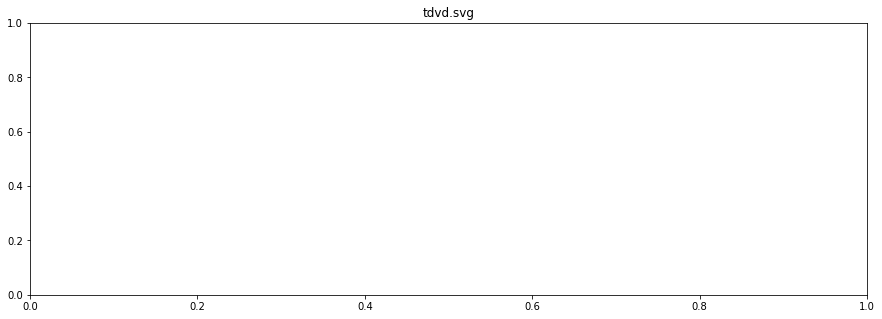

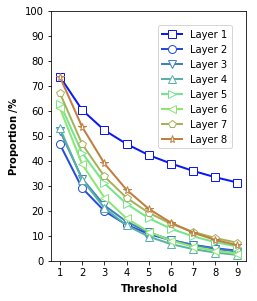

In [81]:
from matplotlib import pyplot as plt
from matplotlib import colors
cdict = {'red':   ((0.0,  0.0, 0.0),
                   (0.5,  0.5, 0.5),
                   (1.0,  1, 1.0)),

         'green': ((0.0,  0, 0.0),
                   (0.5,  1, 1),
                   (1.0,  0, 0.0)),

         'blue':  ((0.0,  1, 1),
                   (0.5,  0.5, 0.5),
                   (1.0,  0, 0))}
cmap = colors.LinearSegmentedColormap('custom', cdict)

plt.figure(figsize=(15,5))
plt.title(fig_name)
proportion_th = np.zeros(shape=(n_layer,range_idx ))

x_value=[]
y1_value=[]
y1_legend=[]
y1_color=[]
y1_marker=[]
for layer in range(n_layer):
    proportion_th[layer][0] = 100 -  proportion[tdvd_range + range_idx*layer]
    x = []
    y = []
    for th in range(1,tdvd_range):
        if stat_type == 'distribution':
            proportion_th[layer][th] = proportion[tdvd_range -th + range_idx*layer] +\
                proportion[tdvd_range +th + range_idx*layer]  
        else:
            proportion_th[layer][th] = (proportion_th[layer][th-1] - proportion[tdvd_range -th + range_idx*layer] -\
                            proportion[tdvd_range +th + range_idx*layer] ) 
        x.append(th)
        y.append(proportion_th[layer][th]/ (proportion_th[layer][0] if relative else 100) *100)
    for th in range(0, tdvd_range):
        print("layer: {}, threshold: {}, real density: {:.1f}".format(layer, th, proportion_th[layer][th]))
    # plt.plot(np.array(x), np.array(y),label="Layer "+str(layer+1), color=cmap(0.1*layer+0.05), linestyle='-',marker='s' )
    # x_value.append(np.array(x))
    y1_value.append(np.array(y))
    y1_legend.append("Layer "+str(layer+1))
    y1_color.append(cmap(0.1*layer+0.05))
    y1_marker.append('s')
y1_marker = ['s', 'o', 'v', '^', '>', '<', 'p', '*', 'd', '+']

fig_name2 = os.path.join('../generate', network,network + '_'+ fig_name)
x_value = range(1, 10)
figsize = (3.5, 4.6)
# legend_loc = (0.55, 0.45) # c3d
# y1_yticks_max = 22
legend_loc = (0.55, 0.45) # 3dunet
y1_yticks_max = 100
print(x_value,
y1_value,
y1_legend,
y1_color,
y1_marker)
print(fig_name2)
cls_plt_fig('').func_plt_fig({   "x_name":"Conv Layers", 
            "x_value": x_value, 
            "x_label" : r"$\bf{Threshold}$",
            "y1_fig_type": "plot",
            "y1_name":y1_legend,
            "y1_value":y1_value, 
            "y1_color":y1_color,
            "y1_linestyle":'x-',
            "y1_label":r"$\bf{Proportion\ /\%}$",
            "y1_marker":y1_marker,
            "y1_markerfacecolor":"white",
            "y1_markeredgewidth": 1,
            "y1_legend": y1_legend,
            "y1_yticks_max":y1_yticks_max,
            "y1_axis_color": (0, 0, 0),
            "len_yticks": 11,
            "linewidth": 2,
            "markersize": 8,
            "family":"Arial",
            "label_size": 10,
            "bar_width": 0.4,
            "xticks": x_value,
            'xticks_fontsize': 10,
            # "plt_text": False,
            "legend_loc": legend_loc,
            'figsize':figsize,
            "fig_name" :fig_name2
})

In [ ]:
# C3D
# compute whole sparsity after given threshold combinations and numbers of IA in each layer
ifm_size = [0.6, 3, 0.75, 1.5, 0.2, 0.4, 0.05, 0.05]
density_th_layer0 = [20, 18, 17, 16, 15, 14 ,13, 12, 11, 10]
for x in range(10, 20):
    proportion_th[0][x] = density_th_layer0[x -10]
def whole_density(ifm_size, proportion_th, threshold, n_layer):
    density = 0
    for i in range(n_layer):
        density += proportion_th[i][threshold[i]]*ifm_size[i] / sum(ifm_size)

    return density

threshold_comb =[   
                    [0, 0, 0, 0, 0, 0, 0, 0],
                    [3, 3, 3, 3, 3, 3, 3, 3],
                    [7, 2, 3, 2, 3, 3, 4, 4],
                    [10,7, 5, 5, 5, 5, 5, 2],
                    [17,9,5, 5, 6, 6, 6, 5]
                ]

for threshold in threshold_comb:
    print("whole density is: {}".format(whole_density(ifm_size, proportion_th, threshold, 8)))

: 

In [ ]:
# 3DUNET
# compute whole sparsity after given threshold combinations and numbers of IA in each layer
ifm_size = [140, 39, 10.4, 3.2, 0.6, 0.35, 2.8, 11.2, 45, 135]
# density_th_layer0 = [20, 18, 17, 16, 15, 14 ,13, 12, 11, 10]
# for x in range(10, 20):
#     proportion_th[0][x] = density_th_layer0[x -10]
def whole_density(ifm_size, proportion_th, threshold, n_layer):
    density = 0
    for i in range(n_layer):
        density += proportion_th[i][threshold[i] if threshold[i]<=10 else 10]*ifm_size[i] / sum(ifm_size)

    return density

threshold_comb =[   
                [0, 0, 0, 0, 0,   0, 0, 0, 0, 0],
                [1, 1, 1, 1, 1,   1, 1, 1, 1, 0],
                [3, 4, 5, 5, 5,   5, 5, 5, 5, 5],
                [3, 8, 11,11,11,  11,11,11,11,11],
                [5, 14,21,22,21,  21,19,22,22,21]
                ]

for threshold in threshold_comb:
    print("whole density is: {}".format(whole_density(ifm_size, proportion_th, threshold, 10)))

: 